<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/RFClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

---
### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

---
### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

---
## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import sklearn.tree as dt
import sklearn.ensemble as en

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import pydotplus as pdot
from IPython.display import Image

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/HR_comma_sep.csv'

<Figure size 720x540 with 0 Axes>

In [0]:
hr_df = pd.read_csv(url)

In [0]:
# now we need to create dummy variables for categorical variables(dtype=object)
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project',
     'average_montly_hours', 'time_spend_company']

categorical_features = ['Work_accident','promotion_last_5years', 'department', 'salary']

In [13]:
categorical_features

['Work_accident', 'promotion_last_5years', 'department', 'salary']

In [14]:
numerical_features

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company']

In [0]:
# A utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [16]:
for c_feature in categorical_features:
    hr_df = create_dummies( hr_df, c_feature )

hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [17]:
#Splitting the data

feature_columns = hr_df.columns.difference( ['left'] )
feature_columns

Index(['Work_accident_1', 'average_montly_hours', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'last_evaluation',
       'number_project', 'promotion_last_5years_1', 'salary_low',
       'salary_medium', 'satisfaction_level', 'time_spend_company'],
      dtype='object')

### Train Test split

In [0]:
train_X, test_X, train_y, test_y = train_test_split( hr_df[feature_columns],
                                                  hr_df['left'],
                                                  test_size = 0.3,
                                                  random_state = 42 )

### Building the model

In [20]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100 )
radm_clf.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [22]:
metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.9864444444444445

### Creating confusion matrix

Text(0.5, 46.5, 'Predicted label')

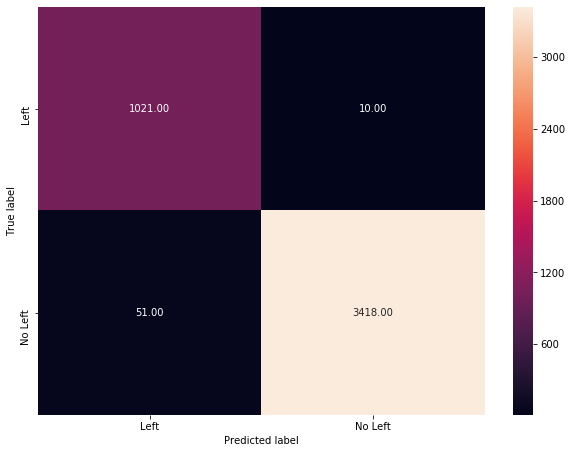

In [24]:
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Find for the important features

In [25]:
radm_clf.feature_importances_

array([0.00924053, 0.15716427, 0.0020358 , 0.00166724, 0.00163001,
       0.00152441, 0.00129832, 0.00116684, 0.00331652, 0.00223872,
       0.00370085, 0.12650584, 0.1837115 , 0.00164929, 0.00710886,
       0.00363687, 0.30630504, 0.18609907])

In [0]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]

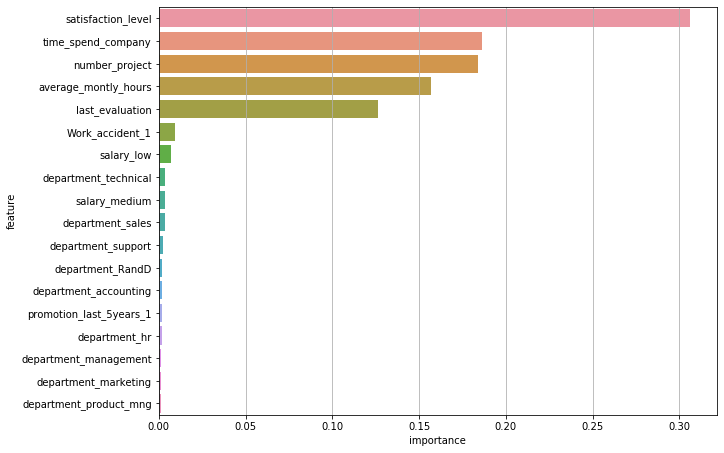

In [28]:
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

<b> Note: </b>
As per the model, the most important features which influence whether to leave the company,in descending order, are

- satisfaction_level
- time_spend_company
- number_project
- average_montly_hours
- last_evaluation
- work_accident